In [1]:
%%capture
from datetime import datetime
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
from IPython.display import display
from sklearn import metrics
plt.rcParams.update({"font.size": 12})
%matplotlib inline

In [2]:
wsb_common_users_data = pd.read_csv("data/wsb_common_users_data.csv",sep=';')
stocks_common_users_data= pd.read_csv("data/stocks_common_users_data.csv",sep=';')
investing_common_users_data= pd.read_csv("data/investing_common_users_data.csv",sep=';')

In [3]:
# Create new column denoting class label and combine into one df
wsb_common_users_data['sub'] = 'wsb'
stocks_common_users_data['sub'] = 'stocks'
investing_common_users_data['sub'] = 'investing'

In [4]:
wsb_common_users_data = wsb_common_users_data[['title','selftext','sub']]

In [5]:
stocks_common_users_data = stocks_common_users_data[['title','selftext','sub']]

In [6]:
investing_common_users_data = investing_common_users_data[['title','selftext','sub']]

In [7]:
investing_common_users_data.head(1)

,title,selftext,sub
0,$NVAX new variant. Approvals. Lift-off.,So the markets are tanking on new variant news...,investing


In [8]:
all_data = wsb_common_users_data.append(investing_common_users_data, ignore_index=True)

In [9]:
all_data = all_data.append(stocks_common_users_data, ignore_index=True)

In [10]:
all_data = all_data[pd.notnull(all_data['selftext'])]

In [11]:
all_data.head(1)

,title,selftext,sub
0,Don't Be A Menace To Hedge Funds By Squeezing ...,"What up, nerds? Long time no post. I come bear...",wsb


In [12]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53135 entries, 0 to 111599
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     53135 non-null  object
 1   selftext  53135 non-null  object
 2   sub       53135 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [13]:
all_data['sub_id'] = all_data['sub'].factorize()[0]
category_id_df = all_data[['sub', 'sub_id']].drop_duplicates().sort_values('sub_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['sub_id', 'sub']].values)
all_data.head()

,title,selftext,sub,sub_id
0,Don't Be A Menace To Hedge Funds By Squeezing ...,"What up, nerds? Long time no post. I come bear...",wsb,0
1,"TSLA Earnings Prediction: They beat estimates,...","As many of you know, [$TSLA - Tesla](https://u...",wsb,0
3,Do you guys follow zack Morris also?,Do you guys play his call outs too? I mean I c...,wsb,0
9,COMPASS Pathways is granted new US patent for ...,"London, UK – 19 October 2021\n\nCOMPASS Pathwa...",wsb,0
10,Indonesia news today: EHang Flying Taxi to Arr...,Ehang stock will rocket soon. \n\nEhang is cur...,wsb,0


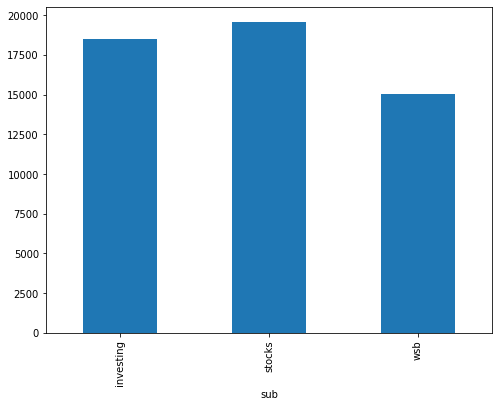

In [14]:
fig = plt.figure(figsize=(8,6))
all_data.groupby('sub').title.count().plot.bar(ylim=0)
plt.show()

In [15]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 1), stop_words='english')
features = tfidf.fit_transform(all_data.title).toarray() #+all_data.selftext
labels = all_data.sub_id
features.shape

(53135, 8103)

In [34]:
N = 20
for Product, category_id in sorted(category_to_id.items()):
   # X{array-like, sparse matrix} of shape (n_samples, n_features)
    #y -array-like of shape (n_samples,)
    #Target vector (class labels).
  features_chi2 = chi2(features, labels == category_id) 

  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]

  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
 

# 'investing':
  . Most correlated unigrams:
. 2020
. gme
. moves
. thread
. tomorrow,
. investing
. r/stocks
. daily
. general
. spitballin
. situation
. personal
. asked
. thread.
. help
. posted
. here.
. basic
. questions
. advice
# 'stocks':
  . Most correlated unigrams:
. stock
. tuesday
. overlooked
. daily
. thursday
. situation
. help
. personal
. moves
. asked
. thread.
. tomorrow,
. basic
. posted
. stocks
. here.
. thread
. questions
. advice
. r/stocks
# 'wsb':
  . Most correlated unigrams:
. moon
. posted
. fucking
. retards
. basic
. calls
. pltr
. puts
. fuck
. tendies
. january
. wsb
. questions
. 2020
. yolo
. 2019
. advice
. gme
. moves
. tomorrow,


In [17]:
X_train, X_test, y_train, y_test = train_test_split(all_data['title'], all_data['sub'], random_state = 0)
count_vect = CountVectorizer(token_pattern=r'[^\s]+')
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [18]:
print(clf.predict(count_vect.transform(["🦍"])))

['investing']


In [19]:
print(clf.predict(count_vect.transform(["🚀"])))

['wsb']


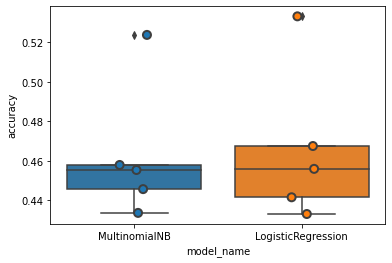

In [20]:
models = [
      MultinomialNB(),
    LogisticRegression(random_state=0,max_iter=3000),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [21]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression    0.466228
MultinomialNB         0.463254
Name: accuracy, dtype: float64

In [22]:
category_id_df['sub'].values

array(['wsb', 'investing', 'stocks'], dtype=object)

C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


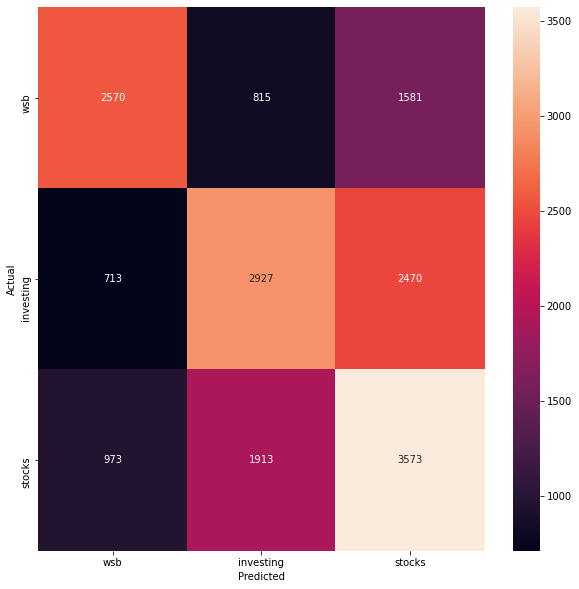

In [23]:
model = LogisticRegression()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, all_data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df['sub'].values, yticklabels=category_id_df['sub'].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [24]:
category_id_df

,sub,sub_id
0,wsb,0
64631,investing,1
86151,stocks,2


In [25]:
from IPython.display import display
for predicted in category_id_df.sub_id:
  for actual in category_id_df.sub_id:
    if predicted != actual and conf_mat[actual, predicted] >= 10:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(all_data.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['sub', 'title']])
      print('')

'investing' predicted as 'wsb' : 713 examples.


,sub,title
65879,investing,Part 2: Cortexyme (CRTX) and GAIN Clinical Tri...
81707,investing,"Premarket SPY trading points to -6.73% open, n..."
69792,investing,DD on WTRH Waitr Holdings
69528,investing,$DISCA YOLO Call Options Trade! This stock wil...
84306,investing,"BlackBerry bets on Kanata, pledging 800 new jobs"
...,...,...
74057,investing,HRC Steel Prices hit ALL-TIME HIGH
67527,investing,"Did Some Heavy DD on This One, massive Potenti..."
74196,investing,Tesla bulls time to go back to your cave!!!!!
84551,investing,TMD TSX



'stocks' predicted as 'wsb' : 973 examples.


,sub,title
98543,stocks,Why Nokia Is My Latest 5G Trade
97586,stocks,$BB DD - no meems
109829,stocks,"You’ve heard of r/wallstreetbets, introducing ..."
102863,stocks,Why is the W K H S stock already $29 ?
100971,stocks,If you bought DoorDash at $180...
...,...,...
97208,stocks,GME buy or stay away?
94416,stocks,wallstreetbets update on Gme second short sque...
103895,stocks,Blackberry- Hidden Gem
98536,stocks,Who’s ready for round 3 of GME tomorrow? I’ve ...



'wsb' predicted as 'investing' : 815 examples.


,sub,title
56196,wsb,Drumbeat to decoupling? China cracking down on...
46170,wsb,Help Choosing my ETFs
45090,wsb,Operation BNG0
9616,wsb,Is there a difference between borrowing margin...
56638,wsb,Epic Fail
...,...,...
181,wsb,World-first Decentralized “ETF-like” product
10695,wsb,I’m Up 24.61% on My Managed Account and Down 2...
10326,wsb,Discussion about stock market youtube channels
3134,wsb,TSLA AI Day August 19th



'stocks' predicted as 'investing' : 1913 examples.


,sub,title
100477,stocks,"I’m worried that if the GOP gets there way, th..."
89453,stocks,AutoUFOs® Trading Apps
88633,stocks,#pton peloton to jump with ny and rest of coun...
92289,stocks,Roast the Portfolio
104526,stocks,Question on assignment
...,...,...
100698,stocks,2021: Time to Rebalance your Portfolio?
107193,stocks,Shocked to see so much buying of dividend ETFs...
106045,stocks,Bank stocks are lower due to the Fed announcem...
92816,stocks,FTC sues Illumina (ILMN) to block vertical int...



'wsb' predicted as 'stocks' : 1581 examples.


,sub,title
39796,wsb,Interactive Brokers now also limiting orders o...
6452,wsb,Social Investing - How do you think it's affec...
219,wsb,NRXP Full DD: Big mover (up 61% yesterday) and...
48107,wsb,TESLA NEWS | NIO SALES | NIKOLA STOCK CRASH | ...
49960,wsb,“I certainly wouldn’t want to be net short the...
...,...,...
50597,wsb,Crazy night
9278,wsb,What stock would you say is good for a call/pu...
8886,wsb,McDonalds Stock
3380,wsb,$SDC SmileDirectClub is one of the most shorte...



'investing' predicted as 'stocks' : 2470 examples.


,sub,title
82893,investing,Cindicator in the Middle East: addressing $4 t...
73040,investing,ANYONE PAYING ATTENTION TO DOGECOIN IN HERE?
64990,investing,Intel Core i5-12600K CPU Up To 50% Faster Than...
76095,investing,$CURR Great News Out - CURE Pharmaceutical Iss...
74551,investing,20k for 10 years
...,...,...
67719,investing,Norwegian startup FLYR AS
66306,investing,Nokia beats Q2 earnings and raises 2021 Outloo...
82360,investing,Growth cloud companies vs Long term blue chip ...
82587,investing,Question on capital gains


In [26]:
model.fit(features, labels)


C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

In [31]:
N = 20
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
 
  print("# '{}':".format(Product))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  

# 'investing':
  . Top unigrams:
       . spitballin
       . 2018)
       . bitcoin
       . questions
       . thread.
       . r/investing
       . basic
       . podcast
       . posted
       . crypto
       . general
       . here.
       . taxable
       . asked
       . tariffs
       . cash?
       . private
       . investing
       . estate
       . 401k
# 'stocks':
  . Top unigrams:
       . r/stocks
       . stocks
       . watchlist
       . read:
       . etsy
       . fast
       . alibaba
       . australis
       . kulr
       . (2021)
       . $maxn
       . jd.com
       . (psfe)
       . interesting!
       . valuation?
       . selling?
       . mgm
       . biontech
       . triterras
       . essay
# 'wsb':
  . Top unigrams:
       . tomorrow,
       . yolo
       . retards
       . tendies
       . fuck
       . autists
       . apes
       . retard
       . autistic
       . fucking
       . gang
       . wsb
       . autist
       . shit
       . 🚀
       . d

In [28]:
print(metrics.classification_report(y_test, y_pred, target_names=all_data['sub'].unique()))

              precision    recall  f1-score   support

         wsb       0.60      0.52      0.56      4966
   investing       0.52      0.48      0.50      6110
      stocks       0.47      0.55      0.51      6459

    accuracy                           0.52     17535
   macro avg       0.53      0.52      0.52     17535
weighted avg       0.52      0.52      0.52     17535



# 'investing':
Feature: , Score:  (0, ('r/stocks', -2.375727133087237))
Feature: , Score:  (1, ('tomorrow,', -2.249143382816583))
Feature: , Score:  (2, ('pltr', -1.8631271515056973))
Feature: , Score:  (3, ('yolo', -1.8026056049573156))
Feature: , Score:  (4, ('meme', -1.7228393571559029))
Feature: , Score:  (5, ('retards', -1.685553735382861))
Feature: , Score:  (6, ('🚀', -1.6656715857959008))
Feature: , Score:  (7, ('fuck', -1.6614198305470413))
Feature: , Score:  (8, ('tendies', -1.5708514645676466))
Feature: , Score:  (9, ('fucking', -1.501371413983525))
Feature: , Score:  (10, ('stonks', -1.4589057093557785))
Feature: , Score:  (11, ('gme.', -1.4459094202919258))
Feature: , Score:  (12, ('gang', -1.4025065253791422))
Feature: , Score:  (13, ('apes', -1.3598647834065358))
Feature: , Score:  (14, ('$clis', -1.3545202885890155))
Feature: , Score:  (15, ('dkng', -1.3252139413298576))
Feature: , Score:  (16, ('uwmc', -1.3224660794305945))
Feature: , Score:  (17, ('autists', -1.2387517

C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128640 missing from current font.
  font.set_text(s, 0, flags=flags)


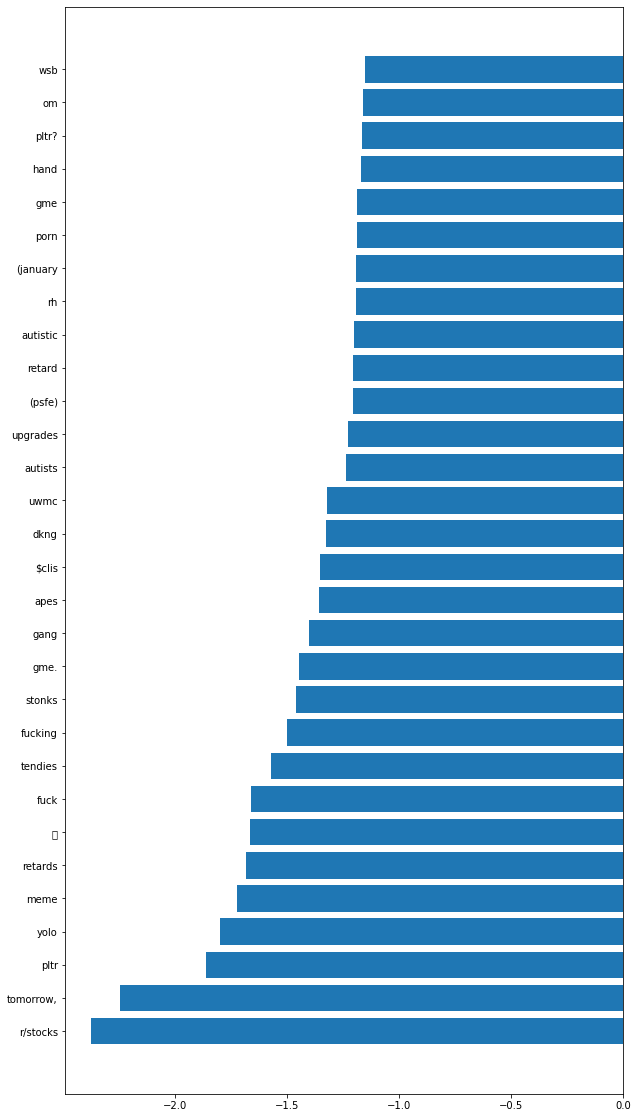

# 'stocks':
Feature: , Score:  (0, ('spitballin', -2.204509632271081))
Feature: , Score:  (1, ('thread', -2.065235666840851))
Feature: , Score:  (2, ('yolo', -1.9635436705762304))
Feature: , Score:  (3, ('tomorrow,', -1.812243139037935))
Feature: , Score:  (4, ('thread.', -1.7489895342235693))
Feature: , Score:  (5, ('r/investing', -1.670151528405864))
Feature: , Score:  (6, ('here.', -1.6259384343626822))
Feature: , Score:  (7, ('tendies', -1.5971322974200755))
Feature: , Score:  (8, ('retards', -1.5787285905264299))
Feature: , Score:  (9, ('shit', -1.5732161121592039))
Feature: , Score:  (10, ('retarded', -1.5644086935304173))
Feature: , Score:  (11, ('listen', -1.4794625394135628))
Feature: , Score:  (12, ('autists', -1.4747099339173324))
Feature: , Score:  (13, ('🚀🚀🚀', -1.4392390609690204))
Feature: , Score:  (14, ('headlines', -1.4056341372146905))
Feature: , Score:  (15, ('2018)', -1.394609600223188))
Feature: , Score:  (16, ('2019', -1.3746239873833872))
Feature: , Score:  (17, 

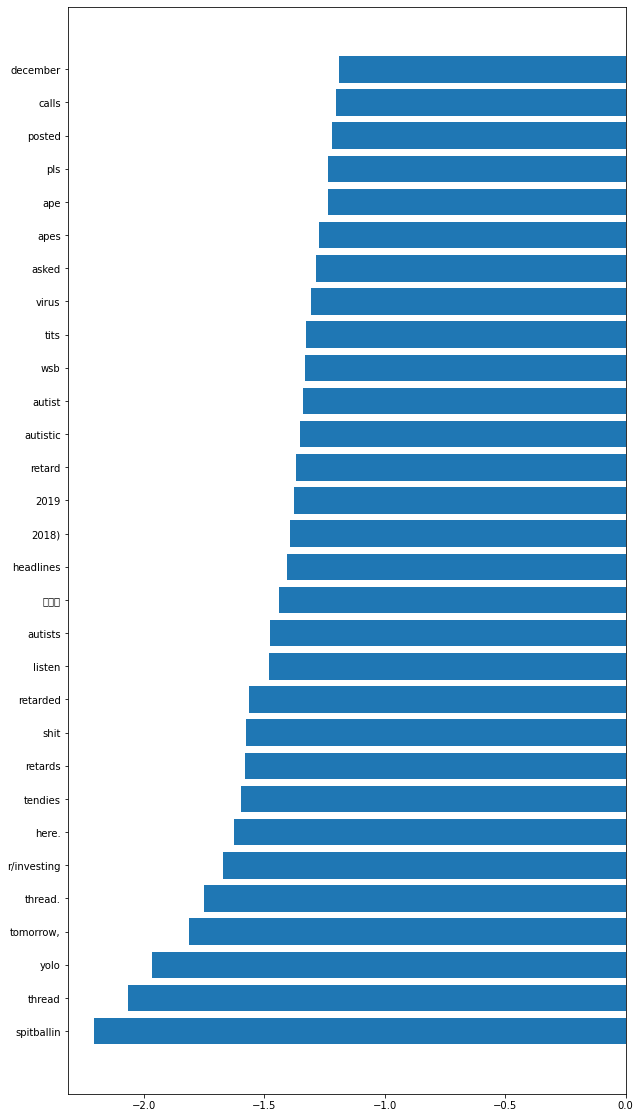

# 'wsb':
Feature: , Score:  (0, ('r/stocks', -4.72558393387711))
Feature: , Score:  (1, ('spitballin', -3.5393443617660605))
Feature: , Score:  (2, ('bitcoin', -2.6973741488527088))
Feature: , Score:  (3, ('crypto', -2.306970612369629))
Feature: , Score:  (4, ('watchlist', -2.2817145508908165))
Feature: , Score:  (5, ('general', -2.2773518760117075))
Feature: , Score:  (6, ('questions', -2.252695327794086))
Feature: , Score:  (7, ('years?', -1.8777753734114404))
Feature: , Score:  (8, ('investing', -1.8132132866727846))
Feature: , Score:  (9, ('portfolio', -1.7875375347132438))
Feature: , Score:  (10, ('investing.', -1.7868517333552454))
Feature: , Score:  (11, ('advice', -1.74301401483769))
Feature: , Score:  (12, ('stocks', -1.7243221158943))
Feature: , Score:  (13, ('alibaba', -1.6934044983297143))
Feature: , Score:  (14, ('etfs?', -1.6478671056693666))
Feature: , Score:  (15, ('dogecoin', -1.637034389736527))
Feature: , Score:  (16, ('berkshire', -1.6162347991018846))
Feature: , Sc

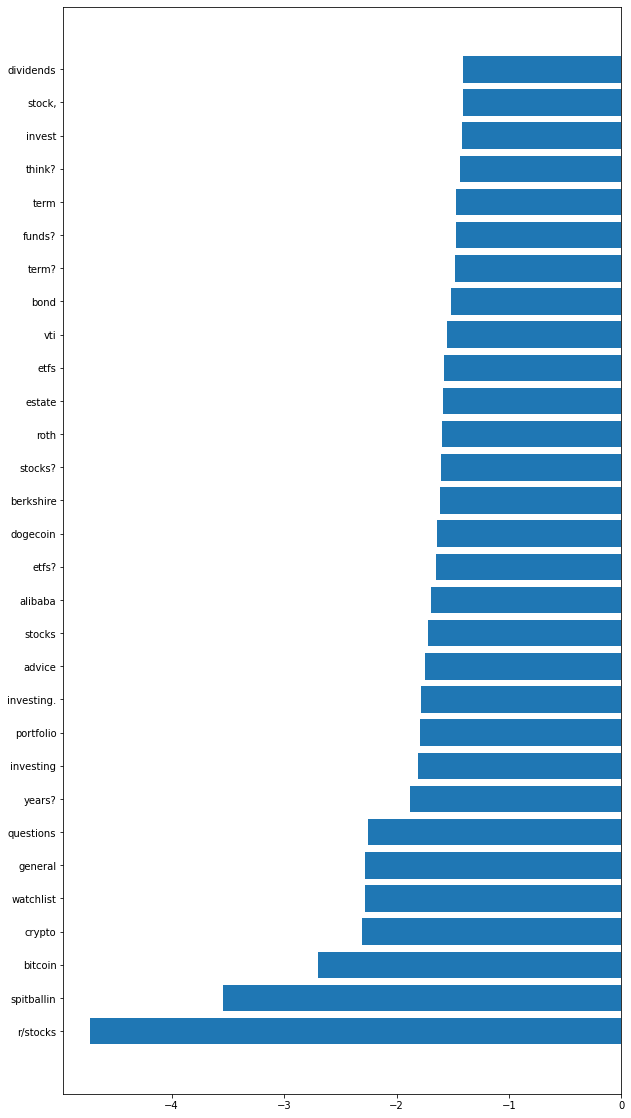

In [29]:
from matplotlib import pyplot
for Product, category_id in sorted(category_to_id.items()):
    print("# '{}':".format(Product))
    # summarize feature importance
    importance = np.sort(model.coef_[category_id])
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    for i,v in enumerate(zip(feature_names[:30],importance[:30])):
        print('Feature: , Score: ',(i,v))
    # plot feature importance
    pyplot.figure(figsize=(10,20))
    pyplot.barh(feature_names[:30], importance[:30])    
    pyplot.show()

## Positive corelation 

# 'investing':
Feature: , Score:  (0, ('ray', 1.2842951772454771))
Feature: , Score:  (1, ('$posh', 1.285969853259988))
Feature: , Score:  (2, ('monday,', 1.2923049348036015))
Feature: , Score:  (3, ('30', 1.3019758153347376))
Feature: , Score:  (4, ('seeks', 1.3139251020260136))
Feature: , Score:  (5, ('advice', 1.3232215858263427))
Feature: , Score:  (6, ('3.5%', 1.3287287809788682))
Feature: , Score:  (7, ('reserve', 1.3307481246964679))
Feature: , Score:  (8, ('proterra', 1.3451003470818765))
Feature: , Score:  (9, ('investment', 1.3520902554271113))
Feature: , Score:  (10, ('dogecoin', 1.3631985542254363))
Feature: , Score:  (11, ('roth', 1.3724113904225936))
Feature: , Score:  (12, ('equity', 1.374883945312714))
Feature: , Score:  (13, ('$rggi', 1.383264235976653))
Feature: , Score:  (14, ('manufacturing', 1.4098516950073972))
Feature: , Score:  (15, ('stellar', 1.4099971205270552))
Feature: , Score:  (16, ('invest?', 1.4106499536909072))
Feature: , Score:  (17, ('$opti', 1.42249

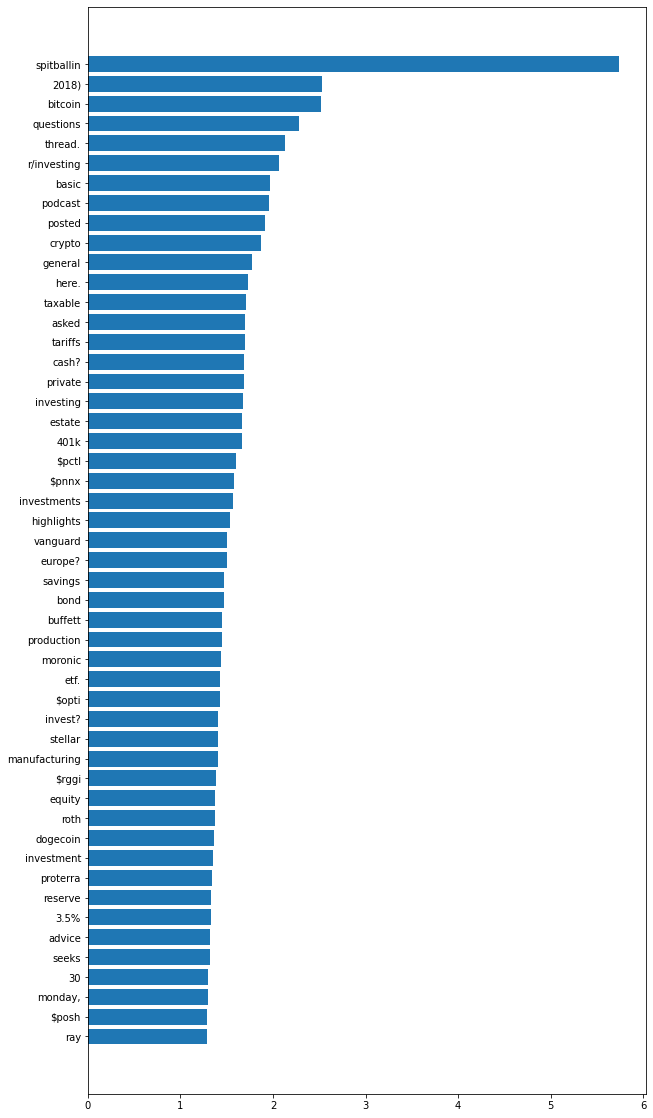

# 'stocks':
Feature: , Score:  (0, ('mmedf', 1.0855127865838874))
Feature: , Score:  (1, ('dominance', 1.086170030372983))
Feature: , Score:  (2, ('frequency', 1.0934349301509723))
Feature: , Score:  (3, ('mergers', 1.0945445795097202))
Feature: , Score:  (4, ('xle', 1.0992500365676259))
Feature: , Score:  (5, ('/r/stocks', 1.1018531052974023))
Feature: , Score:  (6, ('qqq?', 1.103585777741304))
Feature: , Score:  (7, ('thursday', 1.1137659487108273))
Feature: , Score:  (8, ('shll', 1.115070201520868))
Feature: , Score:  (9, ('2nd', 1.1189770768212988))
Feature: , Score:  (10, ('arrival', 1.1207667413499314))
Feature: , Score:  (11, ('penn', 1.1245063768850174))
Feature: , Score:  (12, ('23.', 1.1376444991750525))
Feature: , Score:  (13, ("could've", 1.1415967977182806))
Feature: , Score:  (14, ('overlooked', 1.1439516586773564))
Feature: , Score:  (15, ('$2000', 1.1465315587137066))
Feature: , Score:  (16, ('clir', 1.150060448361937))
Feature: , Score:  (17, ('pops', 1.170331301065192

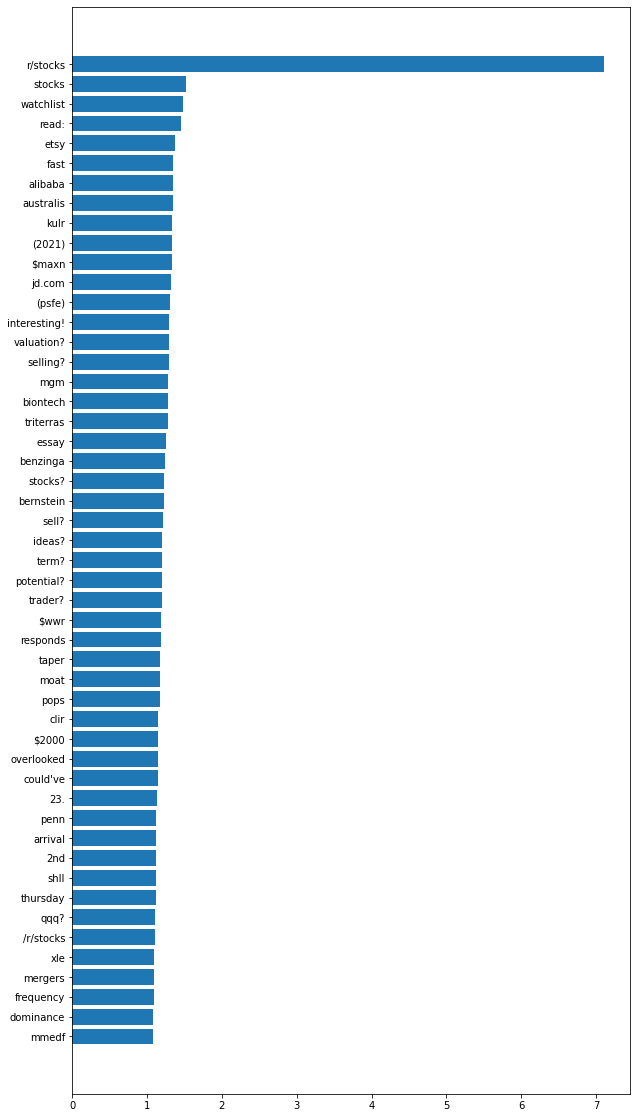

# 'wsb':
Feature: , Score:  (0, ('opposite', 1.5192915837532717))
Feature: , Score:  (1, ('sdc', 1.520495383677516))
Feature: , Score:  (2, ('moon', 1.5215448826940257))
Feature: , Score:  (3, ('january', 1.5224354201982015))
Feature: , Score:  (4, ('unpinned', 1.5320620545575132))
Feature: , Score:  (5, ('strikes', 1.5332651617078354))
Feature: , Score:  (6, ('virus', 1.5350493084065084))
Feature: , Score:  (7, ('twitter!', 1.5391562548760045))
Feature: , Score:  (8, ('melvin', 1.5398473792429996))
Feature: , Score:  (9, ('tards', 1.5513517669666044))
Feature: , Score:  (10, ('gme:', 1.5691229096460981))
Feature: , Score:  (11, ('yall', 1.5716287546419103))
Feature: , Score:  (12, ('uwmc', 1.6748812805784759))
Feature: , Score:  (13, ('tendie', 1.6809060539190799))
Feature: , Score:  (14, ('🚀🚀🚀', 1.68653045011977))
Feature: , Score:  (15, ('porn', 1.6970437525145252))
Feature: , Score:  (16, ('fucked', 1.7077158998575146))
Feature: , Score:  (17, ('2019', 1.715897515585518))
Feature: 

C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128059 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 127752 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\96ank\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128059 missing from current font.
  font.set_text(s, 0, flags=flags)


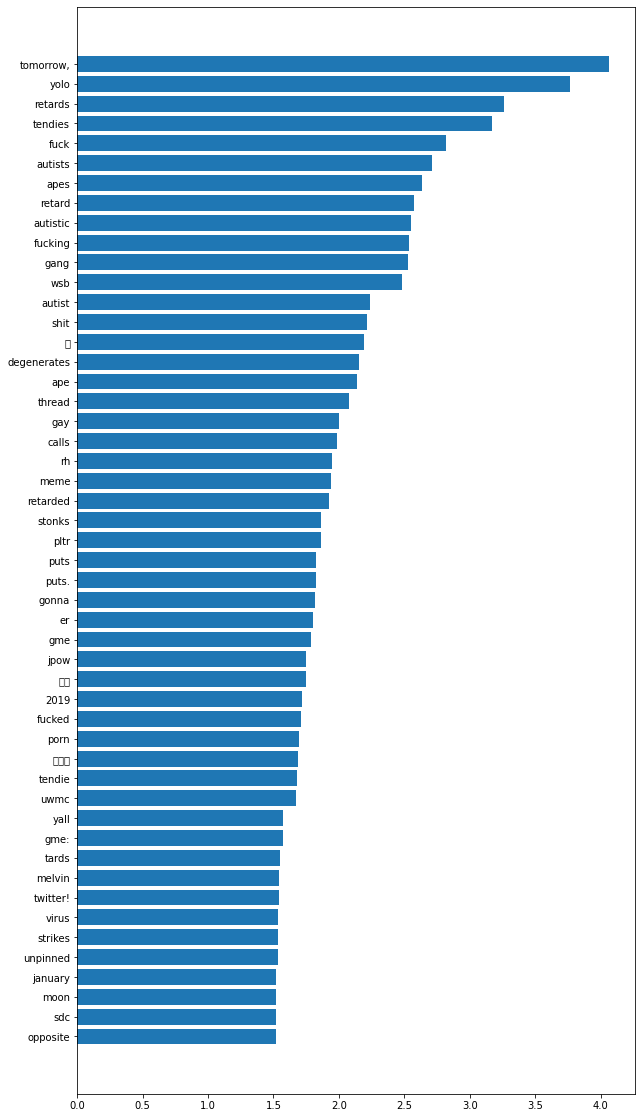

In [30]:
from matplotlib import pyplot
for Product, category_id in sorted(category_to_id.items()):
    print("# '{}':".format(Product))
    # summarize feature importance
    importance = np.sort(model.coef_[category_id])
    indices = np.argsort(model.coef_[category_id])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    
    for i,v in enumerate(zip(feature_names[(len(feature_names[:])-50):],importance[(len(feature_names[:])-50):])):
        print('Feature: , Score: ',(i,v))
    # plot feature importance
    #pyplot.bar([x for x in range(len(importance[:10]))], importance[:10])
    pyplot.figure(figsize=(10,20))
    pyplot.barh(feature_names[len(feature_names[:])-50:], importance[len(feature_names[:])-50:])    
    pyplot.show()